In [1]:
import os
import time
import sys
import scipy
import glob
import importlib

import pandas as pd
import numpy as np

import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl

from datetime import datetime

# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as util
import behavior as butil

In [4]:
util.set_sns_style(style='dark')

In [5]:
%matplotlib notebook

In [415]:
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [416]:
rootdir = '/Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com\
/My Drive/Edge_Tracking/Data/jyr'

In [417]:
experiment = 'stripgrid'
session = '20221101'

# create fig ID
fig_id = os.path.join(rootdir.split(rootdir)[1], experiment, session)
print("Fig ID: {}".format(fig_id))
# Create output dir for figures
src_dir = os.path.join(rootdir, experiment, session)
save_dir = '/Users/julianarhee/Documents/rutalab/data/figures/{}/{}'.format(experiment, session)
save_dir = save_dir.replace(" ", "")

print("Saving figures to:{}    {}".format('\n', save_dir))
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Fig ID: stripgrid/20221101
Saving figures to:
    /Users/julianarhee/Documents/rutalab/data/figures/stripgrid/20221101


In [418]:
log_files = sorted([k for k in glob.glob(os.path.join(src_dir, '*.log'))\
                if 'odorpulse' not in k], key=util.natsort)
print("Found {} tracking files.".format(len(log_files)))
for fi, fpath in enumerate(log_files):
    dfn = os.path.split(fpath)[-1]
    print(fi, dfn)

Found 7 tracking files.
0 11012022-125512_hDC-sytGCaMP7f_fly1_stripgrid_test.log
1 11012022-131904_hDC-sytGCaMP7f_fly2_stripgrid_test.log
2 11012022-134145_hdc-sytGCaMP7f_fly3_stripgrid_test.log
3 11012022-141532_hdc-sytGCaMP7f_fly4_stripgrid_test.log
4 11012022-160300_hdc-sytGCaMP7f_fly1_stripgrid_2p.log
5 11012022-170843_hdc-sytGCaMP7f_fly3_stripgrid_test.log
6 11012022-171227_hdc-sytGCaMP7f_fly3_stripgrid_test.log


In [419]:
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [420]:
cond=None
dlist = []
for fpath in log_files:
    air_only = '_Air' in fpath or '_air' in fpath
    #print(fpath, air_only)
    exp, date_str, fly_id, cond = butil.parse_info_from_file(fpath)
    print(date_str, fly_id, cond)
    df_ = butil.load_dataframe(fpath, mfc_id=None, verbose=False, cond=cond)
    dlist.append(df_)
df0 = pd.concat(dlist, axis=0)
# df0['trial_id'] = ['{}_{}'.format(fly_id, trial) for (fly_id, trial) in \
#                   df0[['fly_id', 'trial']].values]

# df0.loc[df0['condition']=='light', 'condition'] = 'lightonly'

11012022-125512 fly1 hdc-sytgcamp7f
11012022-131904 fly2 hdc-sytgcamp7f
11012022-134145 fly3 hdc-sytgcamp7f
11012022-141532 fly4 hdc-sytgcamp7f
11012022-160300 fly1 hdc-sytgcamp7f
11012022-170843 fly3 hdc-sytgcamp7f
11012022-171227 fly3 hdc-sytgcamp7f


In [421]:
df0[['fly_id', 'trial']].drop_duplicates().groupby('fly_id')['trial'].count()

fly_id
20221101-fly1    2
20221101-fly2    1
20221101-fly3    3
20221101-fly4    1
Name: trial, dtype: int64

In [422]:
fly_ids = sorted(df0['fly_id'].unique(), key=util.natsort)
print(fly_ids)

['20221101-fly1', '20221101-fly2', '20221101-fly3', '20221101-fly4']


#### get borders

In [423]:
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [424]:
#odor_cond = 'hdc-sytgcamp7f'
odor_width=10
grid_sep=200
# get odor border for each fly
odor_borders={}
for (fly_id, trial), currdf in df0.groupby(['fly_id', 'trial']):
    print(fly_id, trial) #, ogrid)
    ogrid = butil.get_odor_grid(currdf, 
                                odor_width=odor_width, grid_sep=grid_sep,
                                use_crossings=True, verbose=False)
    currkey = '{}_{}'.format(fly_id, trial)
    odor_borders[currkey] = list(ogrid.values())

20221101-fly1 11012022-125512
Crossings? True
20221101-fly1 11012022-160300
Crossings? False
... Using default odor min/max, animal did not move in odor
20221101-fly2 11012022-131904
Crossings? True
20221101-fly3 11012022-134145
Crossings? True
20221101-fly3 11012022-170843
Crossings? True
20221101-fly3 11012022-171227
Crossings? True
20221101-fly4 11012022-141532
Crossings? True


In [425]:
odor_borders

{'20221101-fly1_11012022-125512': [(123.47957887798898, 133.55064100395546)],
 '20221101-fly1_11012022-160300': [(-5.3579585785162696, 4.6420414214837304)],
 '20221101-fly2_11012022-131904': [(-6.27212819690034, 3.84138471046166)],
 '20221101-fly3_11012022-134145': [(-56.288583400856, -46.26213482106749)],
 '20221101-fly3_11012022-170843': [],
 '20221101-fly3_11012022-171227': [],
 '20221101-fly4_11012022-141532': [(39.51732903436199, 49.55220444772099)]}

## plot traces

In [407]:
hue_varname='instrip'
palette={True: 'r', False: 'w'}
start_at_odor = True
odor_width=10
odor_lc='lightgray'
odor_lw=0.5

In [408]:
list(plotdf.groupby(['trial_id']).groups.keys())


['20221101-fly1_11012022-125512',
 '20221101-fly1_11012022-160300',
 '20221101-fly2_11012022-131904',
 '20221101-fly3_11012022-134145',
 '20221101-fly3_11012022-170843',
 '20221101-fly3_11012022-171227',
 '20221101-fly4_11012022-141532']

<IPython.core.display.Javascript object>


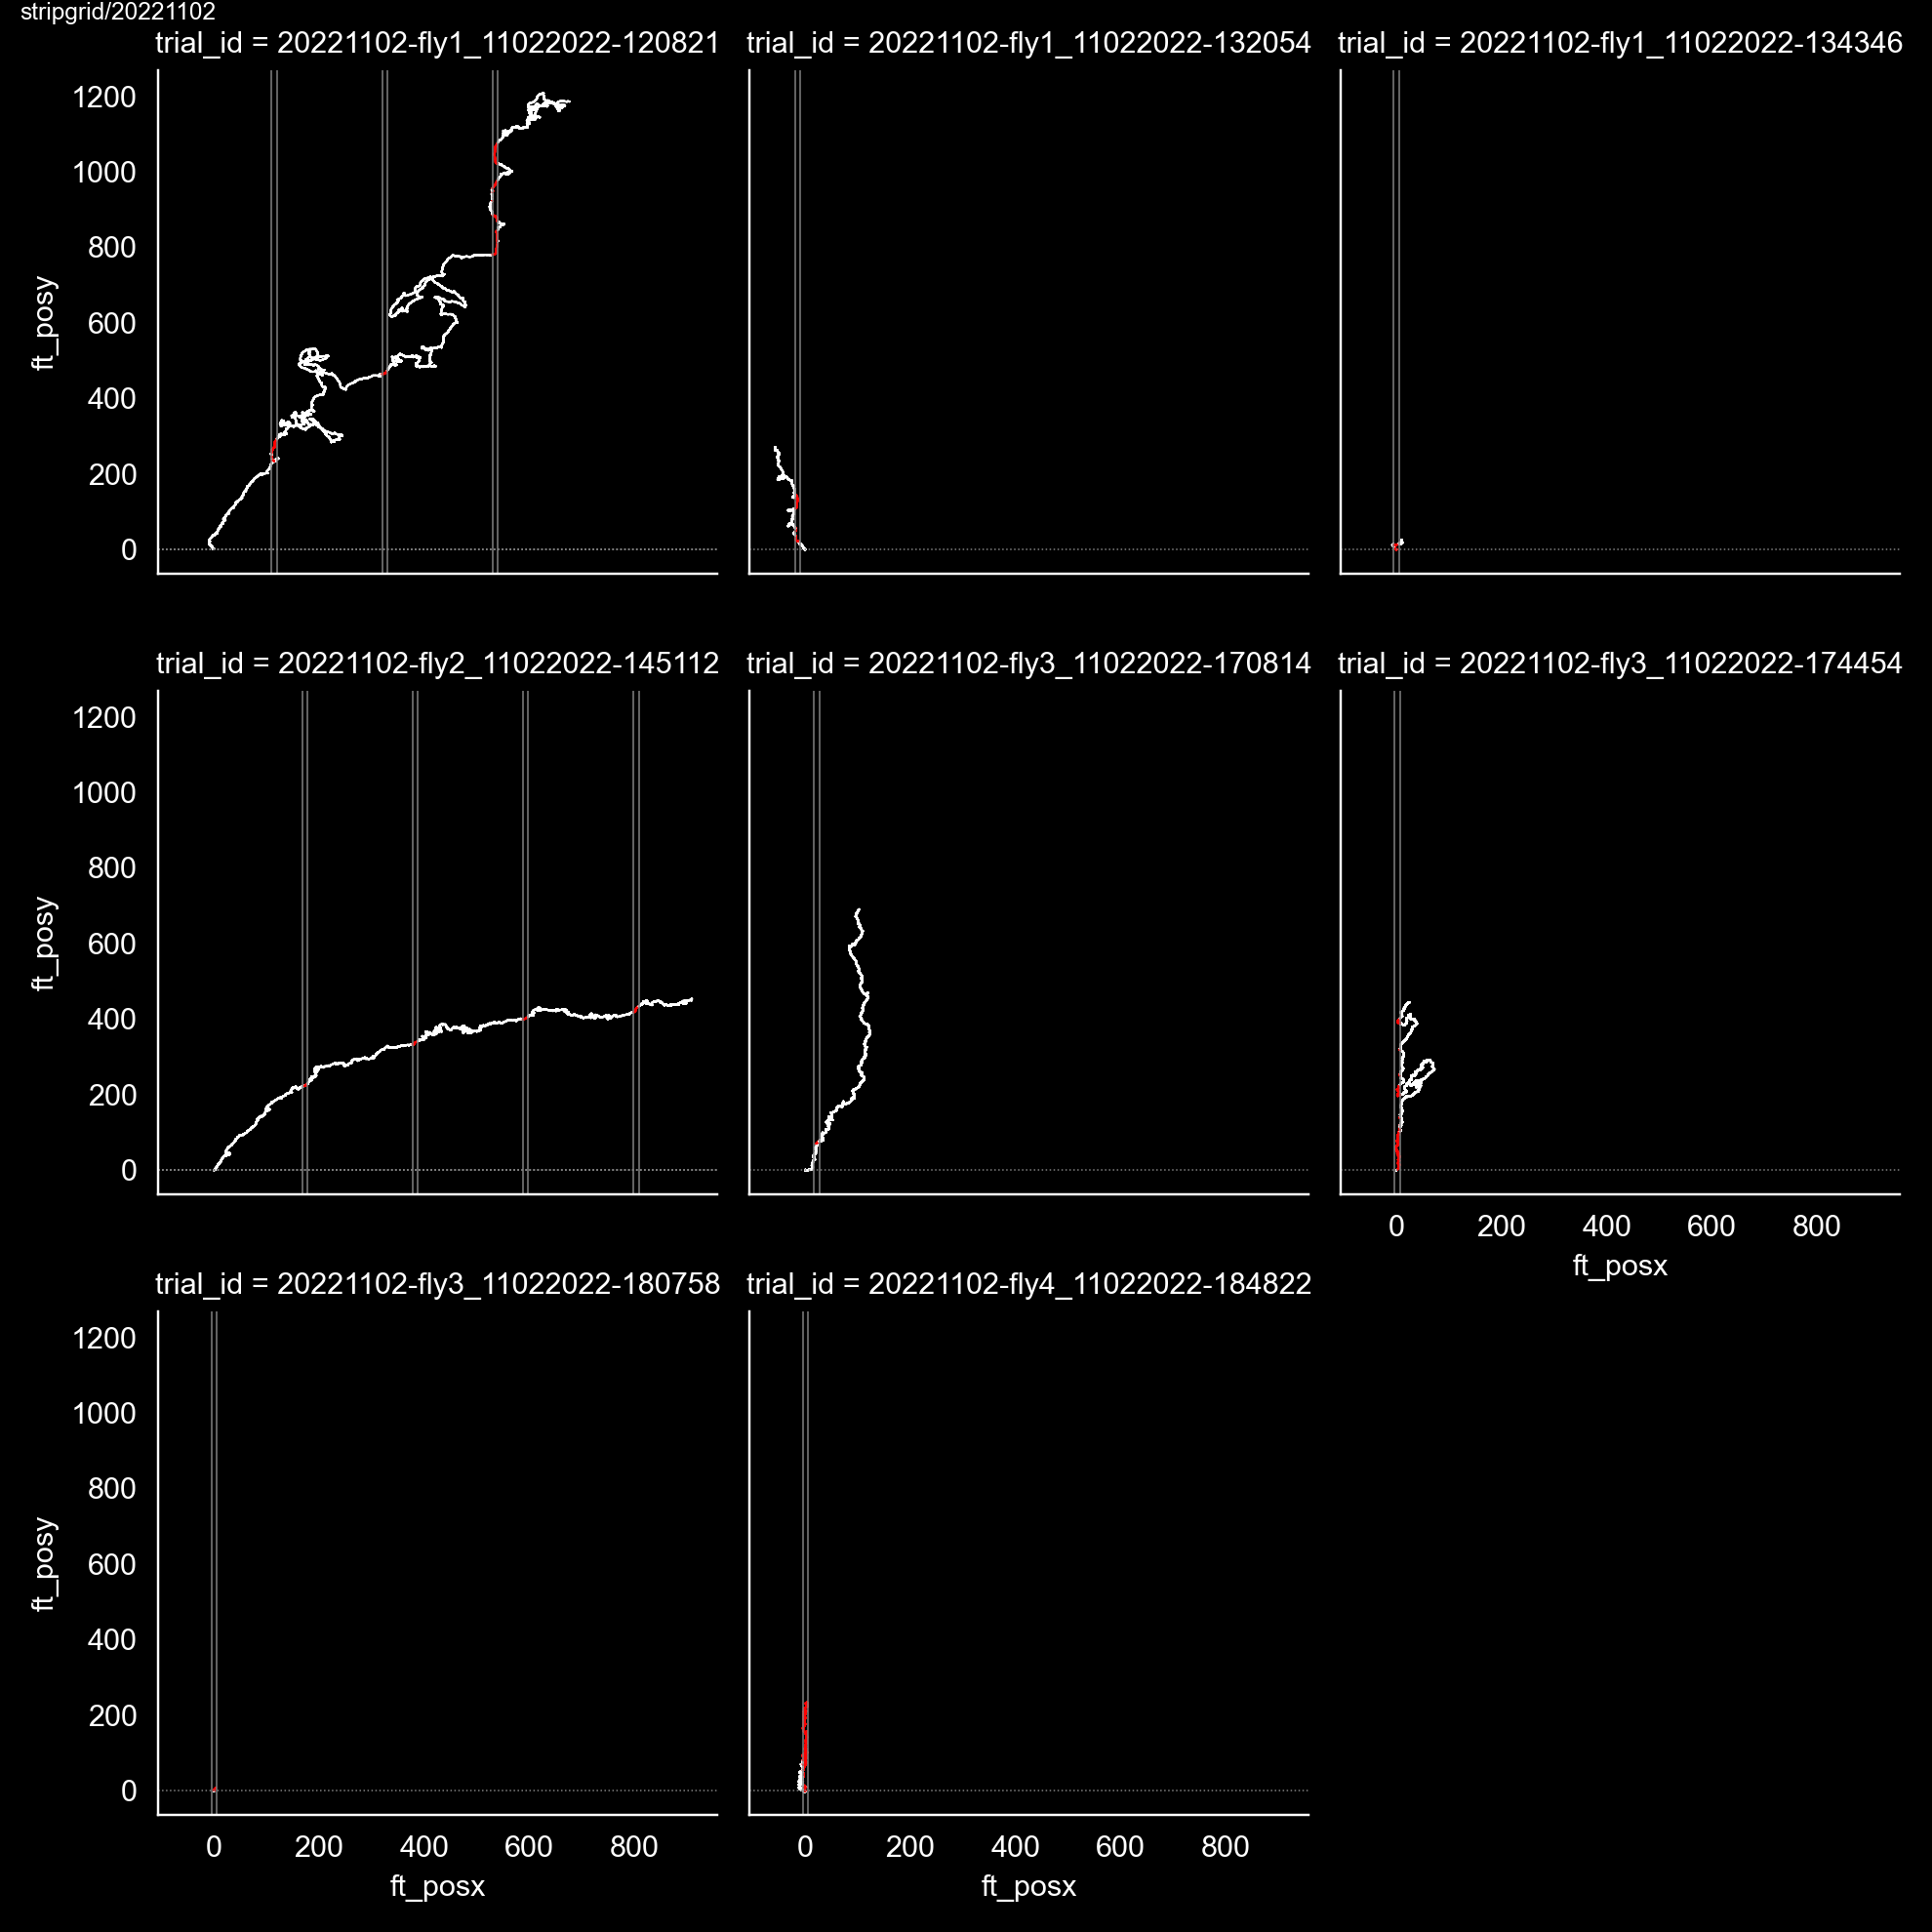

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_1857/799648144.py:14: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for ai, (trial_id, currdf) in enumerate(plotdf.groupby(['trial_id'])):


/Users/julianarhee/Documents/rutalab/data/figures/stripgrid/20221102


In [409]:
# xmin, xmax = (-500, 500)
# ymin, ymax = (-100, 1000)
# odor_xmin, odor_xmax = (-100, 100)
#conds=[odor_cond, 'air']
plotdf = df0.copy()
g = sns.FacetGrid(plotdf, col='trial_id', col_wrap=3, 
                  col_order=list(plotdf.groupby(['trial_id']).groups.keys()))
g.map_dataframe(sns.scatterplot, x="ft_posx", y="ft_posy", hue=hue_varname,
               s=0.5, edgecolor='none', palette=palette) #, palette=palette)
pl.show()
util.label_figure(g.fig, fig_id)

# add odor corridor to facet grid
for ai, (trial_id, currdf) in enumerate(plotdf.groupby(['trial_id'])):
    ax = g.axes[ai]
    for obound in odor_borders[trial_id]:
        odor_xmin, odor_xmax = obound
        butil.plot_odor_corridor(ax, odor_xmin=odor_xmin, odor_xmax=odor_xmax)

figname = 'trajectories_by_fly'
pl.savefig(os.path.join(save_dir, '{}.png'.format(figname))) #, dpi=dpi)
print(save_dir)

In [412]:
min(ax.get_xlim())


-106.0877770931682